# Image compression using Principal Component Analysis

JMA May 2024

In [199]:
%matplotlib inline
# utils
import os, re, math

# numbers
import numpy as np
import numpy.random as rn
import pandas as pd

# stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plots
import matplotlib.pyplot as plt
import seaborn as sns


In [200]:
# globals

# DATA_DIR = './hw-7-data'

ROW_COUNT = 28
IMAGE_SET_SIZE = 6

GAUSSIAN_NOISE_STD_DEV = 10
PCA_COMPONENT_COUNT = 4



## Loading the EMNIST dataset

This celebrated dataset of digitized hand-written digits is widely used as a test set for image recognition. Because it is small, and well studied, it is used here for image compression tests

Source:  

    https://www.nist.gov/itl/products-and-services/emnist-dataset


In [201]:
# We choose one of the datasets, of 40000 digits, digitized on a 28 by 28 grid. 

# os.chdir(DATA_DIR)
emnist__digits = pd.read_csv('emnist-digits-test.csv', header=None, sep=',', dtype= 'uint')
print(emnist__digits.shape)
emnist__digits.head()

(40000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Some useful functions

In [202]:
def extract_image_vector(index, dataset=emnist__digits):
    'Return a square matrix from a row in the Pandas DataFrame.'
    return emnist__digits.values[index,1:]

def add_gaussian_noise(the_vector, std_dev=GAUSSIAN_NOISE_STD_DEV):
    'Add zero mean' 
    noise = rn.normal(0,std_dev, len(the_vector) )
    return the_vector + noise

def mean_square_error(modified_vector, original_image_vector):
    'A distance measure between two image matrices'
    n = sum(original_image_vector.shape)
    # print('n', n)
    if n != sum(modified_vector.shape):
        print(f'Vector lengths do not match: {n}')
        return None
    # Compute mean sum of squares
    rmse = math.sqrt(np.square(modified_vector - original_image_vector).sum())/n
    return rmse

# Test - comparing a vector with iteself should equal 0
mean_square_error(emnist__digits.values[9,1:], emnist__digits.values[9,1:])

0.0

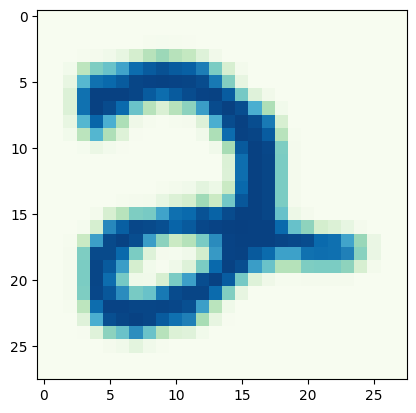

2

In [203]:


def view_one_image(index, dataset=emnist__digits):
    '''Take one row of the data that contains one image, 
    reshape it to a square for display, and return the class'''
    the_class = emnist__digits.values[index, 0]
    
    the_vector = extract_image_vector(index, dataset)
    
    # test adding some noise to the image
    # the_vector = add_gaussian_noise(extract_image_vector(index, dataset), std_dev=2*GAUSSIAN_NOISE_STD_DEV)

    image = plt.imshow(the_vector.reshape(ROW_COUNT,ROW_COUNT).T, cmap='GnBu')
    plt.show(image)
    return the_class

view_one_image(4)

## Compute the PCA decomposition of one image. 

In [204]:
pca_model = PCA(n_components=PCA_COMPONENT_COUNT)

# Select a matrix of multiple images
DIGIT = 2
images = np.zeros((IMAGE_SET_SIZE, ROW_COUNT*ROW_COUNT))
row = 0
for k in range(emnist__digits.shape[0]):
    a_digit = emnist__digits.values[k, 0]
    # print(a_digit, end = ':')
    if a_digit == DIGIT:
        # print(k, a_digit)
        images[row,:] = extract_image_vector(k)
        row +=1
        if row >= IMAGE_SET_SIZE:
            break
    
print(f'Training shape {images.shape}')
pca_model.fit(images)
image_transform = pca_model.transform(images)
image_transform.shape

# print(image_transform)

Training shape (6, 784)


(6, 4)

## Visualizing the first six eigenvector components 

(4, 784)


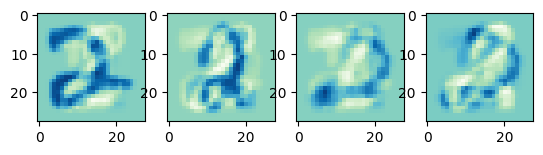

In [206]:
print(pca_model.components_.shape)
display_cnt = min(PCA_COMPONENT_COUNT, 6)
# plt.imshow(images[4,:].reshape(ROW_COUNT,ROW_COUNT).T, cmap='GnBu')
fit, axes = plt.subplots(1,display_cnt)
for k in range(display_cnt):  
    axes[k].imshow(pca_model.components_[k,:].reshape(ROW_COUNT,ROW_COUNT).T, cmap='GnBu')

In [ ]:
reconstructed_image = pca_model.inverse_transform(image_transform)
reconstructed_image.shape

(6, 784)

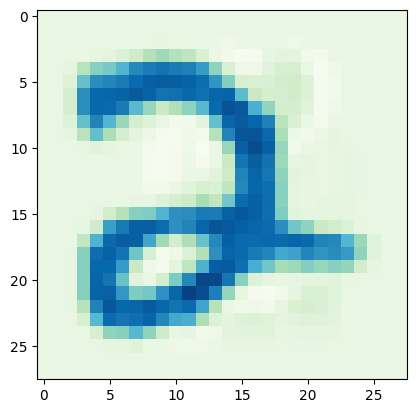

In [ ]:
plt.imshow(reconstructed_image[0,:].reshape((ROW_COUNT,ROW_COUNT)).T, cmap='GnBu')

In [ ]:
# Compute the variation of the reconstructed image from the original
mean_square_error(emnist__digits.values[1,1:], reconstructed_image[0,:])

3.7512758762194327

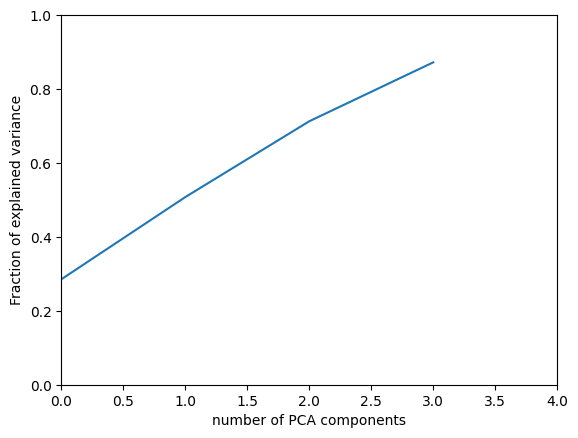

In [ ]:

cummulative_variance = pca_model.explained_variance_ratio_.cumsum()
plt.figure()
plt.axis([0, PCA_COMPONENT_COUNT,0,1])
plt.xlabel("number of PCA components")
plt.ylabel('Fraction of explained variance')
plt.plot(cummulative_variance)

## Alternate decomposition - consider each row in the image as a sample vector

In [ ]:
pca_model = PCA(n_components=PCA_COMPONENT_COUNT)

# Select a matrix of multiple images
DIGIT = 2
the_vector = add_gaussian_noise(extract_image_vector(4,), 0)
train_image = the_vector.reshape(ROW_COUNT,ROW_COUNT).T
    
print(f'Training shape {train_image.shape}')
image_pca_model = PCA(n_components=28)
image_pca_model.fit(train_image)
image_space = image_pca_model.transform(train_image)
image_space.shape

Training shape (28, 28)


(28, 28)

(28, 28)
3.0129786264086667e-15


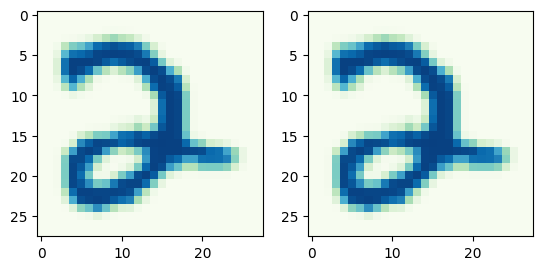

In [ ]:
image_reconstruction = image_pca_model.inverse_transform(image_space)
print(image_reconstruction.shape)
fit, axes = plt.subplots(1,2)
axes[0].imshow(train_image, cmap='GnBu')
axes[1].imshow(image_reconstruction, cmap='GnBu')
print(mean_square_error(image_reconstruction.reshape(784), train_image.reshape(784)))

### How does error change for a noisy image, with the number of components? 

In [ ]:
extract_image_vector(1,).shape

(784,)

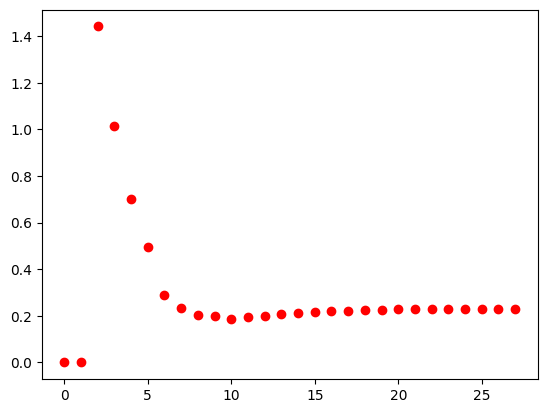

In [ ]:
def vary_components(image_vector, noise_level):
    the_vector = add_gaussian_noise(image_vector, noise_level)
    train_image = the_vector.reshape(ROW_COUNT,ROW_COUNT)
    errors = np.zeros(ROW_COUNT)
    
    for component_count in range(2,ROW_COUNT):
        v_pca_model = PCA(n_components=component_count)
        v_pca_model.fit(train_image)
        image_space = v_pca_model.transform(train_image)
        image_reconstruction = v_pca_model.inverse_transform(image_space)
        base_error = mean_square_error(the_vector, image_vector)
        errors[component_count] =  mean_square_error(image_reconstruction.reshape(784), image_vector.reshape(784))

    return errors

plt.plot(vary_components(extract_image_vector(1,), 6), 'or')
